In [1]:
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from umap import UMAP

import torch
from torch.nn import Linear, MSELoss, Embedding
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [2]:
torch.__version__

'1.13.0+cpu'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Get (preprocessed) data

In [4]:
user_path = './datasets/20221108_movieLens100k_users.csv'
movie_path = './datasets/20221108_movieLens100k_movies.csv'
rating_path = './datasets/20221108_movieLens100k_ratings.csv'

user_df, movie_df, rating_df = pd.read_csv(user_path), pd.read_csv(movie_path), pd.read_csv(rating_path)

user_df.shape, movie_df.shape, rating_df.shape

((671, 1), (9125, 24), (100004, 3))

In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  671 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9125 non-null   int64  
 1   Action       9125 non-null   int64  
 2   Adventure    9125 non-null   int64  
 3   Animation    9125 non-null   int64  
 4   Children     9125 non-null   int64  
 5   Comedy       9125 non-null   int64  
 6   Crime        9125 non-null   int64  
 7   Documentary  9125 non-null   int64  
 8   Drama        9125 non-null   int64  
 9   Fantasy      9125 non-null   int64  
 10  Film-Noir    9125 non-null   int64  
 11  Horror       9125 non-null   int64  
 12  IMAX         9125 non-null   int64  
 13  Musical      9125 non-null   int64  
 14  Mystery      9125 non-null   int64  
 15  Romance      9125 non-null   int64  
 16  Sci-Fi       9125 non-null   int64  
 17  Thriller     9125 non-null   int64  
 18  War          9125 non-null   int64  
 19  Wester

In [7]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [8]:
assert not user_df.isnull().values.any(), 'Null values in user dataset!'
assert not movie_df.isnull().values.any(), 'Null values in movie dataset!'
assert not rating_df.isnull().values.any(), 'Null values in rating dataset!'

### UMAP - Plot dimension reduction

In [9]:
plot_embeddings = np.load('./datasets/20221118_np_plot_embeddings.npy')
plot_embeddings.shape

(9125, 384)

In [10]:
umap_2d = UMAP(n_neighbors=15, n_components=2, init='random', random_state=11)
umap_4d = UMAP(n_neighbors=15, n_components=4, init='random', random_state=11)

plot_embed_umap_2d = umap_2d.fit_transform(plot_embeddings)
plot_embed_umap_4d = umap_4d.fit_transform(plot_embeddings)

plot_embed_umap_2d.shape, plot_embed_umap_4d.shape

((9125, 2), (9125, 4))

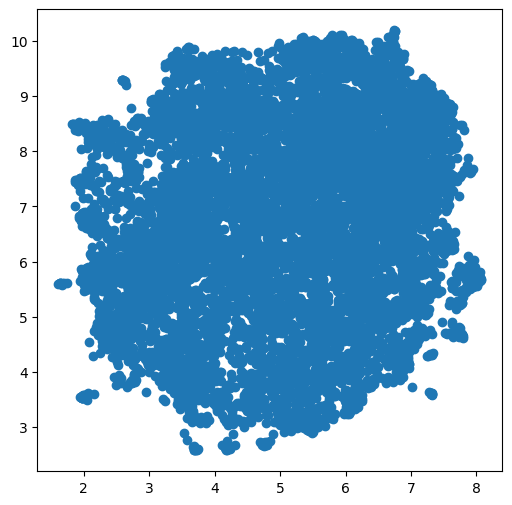

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(x=plot_embed_umap_2d[:,0], y=plot_embed_umap_2d[:,1])
plt.show()

### Data profiling


C:\Users\roman\AppData\Local\Temp\ipykernel_35464\1872624327.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  movie_df[movie_features].hist(bins=30, ax=ax)


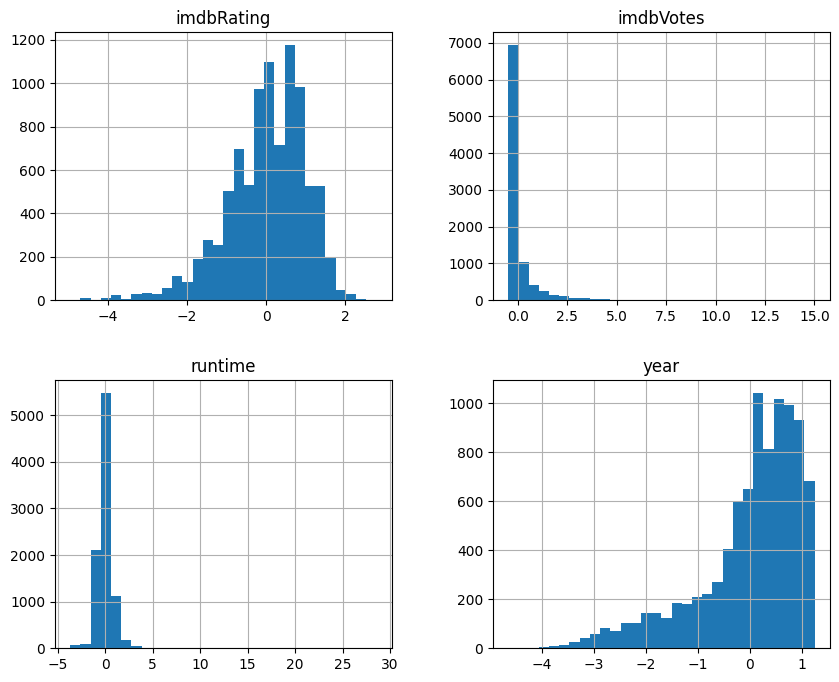

In [12]:
_, ax = plt.subplots(figsize=(10,8))

movie_features = movie_df.columns[-4:]
movie_df[movie_features].hist(bins=30, ax=ax)
plt.show()

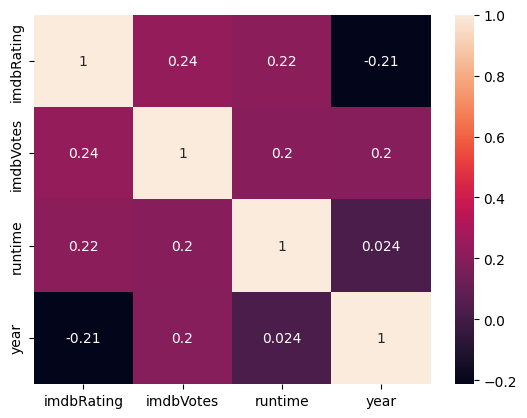

In [13]:
corr_matrix = movie_df[movie_features].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

### Encoding & Scaling data

In [14]:
user_encoder, movie_encoder = LabelEncoder(), LabelEncoder()
scaler = StandardScaler()

In [15]:
user_df['userId'] = user_encoder.fit_transform(user_df['userId'])
movie_df['movieId'] = movie_encoder.fit_transform(movie_df['movieId'])

rating_df['userId'] = user_encoder.transform(rating_df['userId'])
rating_df['movieId'] = movie_encoder.transform(rating_df['movieId'])

In [16]:
features_to_scale = ['imdbRating', 'imdbVotes', 'runtime', 'year']
scaled_features = scaler.fit_transform(movie_df[features_to_scale])
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale)

In [17]:
movie_df.drop(columns=features_to_scale, axis=1, inplace=True)
movie_df = pd.concat([movie_df, scaled_features_df], axis=1)
movie_df.head()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,1.528928,5.144229,-0.876122,0.158905
1,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0.174897,1.394602,-0.058951,0.158905
2,2,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905
3,3,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905


In [18]:
movie_df.describe()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year
count,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,...,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9.125000e+03,9.125000e+03,9.125000e+03,9.125000e+03
mean,4562.000000,0.169315,0.122411,0.048986,0.063890,0.363288,0.120548,0.054247,0.478356,0.071671,...,0.059507,0.169315,0.086795,0.189479,0.040219,0.018411,-2.725369e-17,-1.245883e-17,4.672062e-18,-1.245883e-17
std,2634.304937,0.375051,0.327778,0.215851,0.244571,0.480973,0.325619,0.226516,0.499559,0.257957,...,0.236584,0.375051,0.281549,0.391910,0.196484,0.134439,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.951079e+00,-4.954719e-01,-3.682925e+00,-4.650468e+00
25%,2281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.988353e-01,-4.503885e-01,-4.497720e-01,-3.582321e-01
50%,4562.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.818045e-02,-3.532937e-01,-1.300096e-01,2.623321e-01
75%,6843.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.551962e-01,-3.114708e-17,3.318695e-01,7.277552e-01
max,9124.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.786243e+00,1.500774e+01,2.857755e+01,1.244892e+00


In [19]:
# _, ax = plt.subplots(figsize=(10,8))

# movie_df[movie_features].hist(bins=30, ax=ax)
# plt.show()

In [20]:
# safe_date = datetime.now().strftime('%Y%m%d')
# user_df.to_csv(f'./datasets/{safe_date}_movieLens100k_users.csv', index=False)
# movie_df.to_csv(f'./datasets/{safe_date}_movieLens100k_movies.csv', index=False)
# rating_df.to_csv(f'./datasets/{safe_date}_movieLens100k_ratings.csv', index=False)

In [21]:
rating_df

,userId,movieId,rating
0,0,1087,2.0
1,0,1083,3.5
2,0,1140,1.0
3,0,1111,2.5
4,0,1017,2.0
...,...,...,...
99999,670,3113,2.0
100000,670,3199,3.5
100001,670,3213,4.0
100002,670,3220,3.5


### Create Pytorch Geometric (heterogenious) Dataset

In [22]:
x_user = torch.eye(len(user_df['userId'].values))
x_user.size()

torch.Size([671, 671])

In [23]:
x_movie = movie_df.drop(columns=['movieId'], axis=1)
x_movie = x_movie.values
x_movie = np.concatenate((x_movie, plot_embed_umap_4d), axis=1)
x_movie = torch.Tensor(x_movie)
x_movie.size()

torch.Size([9125, 27])

In [24]:
edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index.size(), edge_index

(torch.Size([2, 100004]),
 tensor([[   0,    0,    0,  ...,  670,  670,  670],
         [1087, 1083, 1140,  ..., 3213, 3220, 3223]]))

In [25]:
edge_label = torch.Tensor(rating_df['rating'].values)
edge_label.size(), edge_label

(torch.Size([100004]),
 tensor([2.0000, 3.5000, 1.0000,  ..., 4.0000, 3.5000, 3.5000]))

In [26]:
data = HeteroData()
data['user'].x = x_user
data['movie'].x = x_movie

data[('user', 'rates', 'movie')].edge_index = edge_index
data[('user', 'rates', 'movie')].edge_label = edge_label

data

HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 27] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  }
)

In [27]:
data = ToUndirected()(data)
# data = AddSelfLoops()(data)
# data = NormalizeFeatures()(data)
del data[('movie', 'rev_rates', 'user')].edge_label
data

HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 27] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)

In [28]:
# data = data.to(device)

### Train / Test Split

In [29]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [30]:
print('Train:', train_data)
# print('Val:', val_data)
# print('Test:', test_data)

Train: HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 27] },
  (user, rates, movie)={
    edge_index=[2, 80004],
    edge_label=[80004],
    edge_label_index=[2, 80004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80004] }
)


In [31]:
# Slicing edge label to get the corresponding split (hence this gives train split)
train_data['user', 'movie'].edge_label_index.size(), train_data['user', 'movie'].edge_label_index

(torch.Size([2, 80004]),
 tensor([[ 176,  483,  546,  ...,  284,  247,  294],
         [1220,  610, 3873,  ..., 1360, 1669, 2334]]))

In [32]:
train_data['user', 'movie'].edge_label.size(), train_data['user', 'movie'].edge_label

(torch.Size([80004]), tensor([3., 4., 4.,  ..., 3., 4., 4.]))

In [33]:
# fetaure matrix for all the node types
data.x_dict

{'user': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 'movie': tensor([[ 0.0000,  1.0000,  1.0000,  ..., -1.4143,  2.3659,  1.5699],
         [ 0.0000,  1.0000,  0.0000,  ..., -0.8378,  2.7128,  2.0274],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0355,  3.2111,  2.5577],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8560,  5.6256,  1.9583],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.9886,  2.9998,  1.8537],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.9370,  4.8003,  1.2202]])}

### GNN Model

In [34]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=64).to(device)

In [35]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters())

In [36]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [37]:
EPOCHS = 300
train_losses, val_losses, test_losses = [], [], []
for epoch in range(1, EPOCHS+1):
    train_loss = train()
    # train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    
    train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
    
    print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
          f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')
    # break

Epoch: 001	Train: 3.5342	Val: 3.2420	Test: 3.2738
Epoch: 002	Train: 3.2490	Val: 2.9519	Test: 2.9829
Epoch: 003	Train: 2.9567	Val: 2.6594	Test: 2.6893
Epoch: 004	Train: 2.6627	Val: 2.3473	Test: 2.3755
Epoch: 005	Train: 2.3489	Val: 2.0120	Test: 2.0376
Epoch: 006	Train: 2.0114	Val: 1.6613	Test: 1.6824
Epoch: 007	Train: 1.6580	Val: 1.3262	Test: 1.3389
Epoch: 008	Train: 1.3208	Val: 1.0910	Test: 1.0883
Epoch: 009	Train: 1.0860	Val: 1.1072	Test: 1.0855
Epoch: 010	Train: 1.1077	Val: 1.3076	Test: 1.2770
Epoch: 011	Train: 1.3138	Val: 1.4434	Test: 1.4105
Epoch: 012	Train: 1.4520	Val: 1.4543	Test: 1.4213
Epoch: 013	Train: 1.4629	Val: 1.3764	Test: 1.3446
Epoch: 014	Train: 1.3837	Val: 1.2526	Test: 1.2235
Epoch: 015	Train: 1.2572	Val: 1.1338	Test: 1.1098
Epoch: 016	Train: 1.1352	Val: 1.0645	Test: 1.0482
Epoch: 017	Train: 1.0627	Val: 1.0604	Test: 1.0527
Epoch: 018	Train: 1.0563	Val: 1.1009	Test: 1.1003
Epoch: 019	Train: 1.0957	Val: 1.1513	Test: 1.1553
Epoch: 020	Train: 1.1457	Val: 1.1870	Test: 1.1934


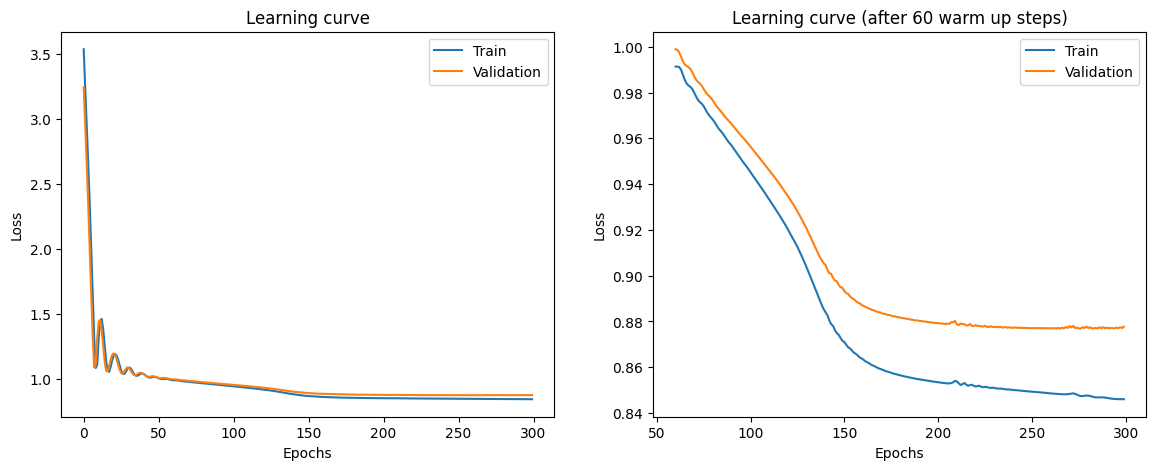

In [38]:
SKIP_WARM_UP_STEPS = 60

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax0.plot(train_losses, label='Train')
ax0.plot(val_losses, label='Validation')
ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), train_losses[SKIP_WARM_UP_STEPS:], label='Train')
ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), val_losses[SKIP_WARM_UP_STEPS:], label='Validation')
ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()

### Inspect test results

In [39]:
model.eval()
pred = model(test_data.x_dict, test_data.edge_index_dict,
                test_data['user', 'movie'].edge_label_index)
pred = pred.clamp(min=0, max=5)
target = test_data['user', 'movie'].edge_label.float()
rmse = F.mse_loss(pred, target).sqrt()

In [40]:
pred[:20], target[:20]

(tensor([3.0905, 3.5806, 2.8922, 3.6335, 3.6143, 3.9650, 3.4395, 3.7681, 3.7759,
         3.6506, 2.9432, 2.6136, 2.8993, 4.0106, 2.9193, 4.2495, 4.4955, 2.4207,
         3.6813, 3.8915], grad_fn=<SliceBackward0>),
 tensor([2.5000, 2.0000, 2.0000, 4.0000, 3.0000, 5.0000, 4.0000, 4.5000, 4.0000,
         4.5000, 3.0000, 4.0000, 3.0000, 3.5000, 1.0000, 5.0000, 5.0000, 4.0000,
         3.5000, 3.0000]))

#### Evaluation

Mean squared Error (MSE) can be used as loss function. However, it is not a well suited metric to evaluate the model's recommendations. `Recall@k` fits better for evaluating the recommendations done by the model.  

In [41]:
def create_rec_dict_per_user() -> dict:
    """ Return a dictionnairy, with link predictions for each user.
    
        The dict keys are userId's and values a list of tuples. The
        first tuple value is the predicted rating and the second one
        the ground truth (rating). """

    user_rec_dict = defaultdict(list)
    test_users_unique = test_data['user', 'movie'].edge_label_index[0].unique()

    with torch.no_grad():
        for user_id in tqdm(test_users_unique):
            user_id = user_id.item()

            idxs = (test_data['user', 'movie'].edge_label_index[0] == user_id).nonzero().squeeze()
            edge_idxs = test_data['user', 'movie'].edge_label_index[:,idxs]
            
            true_ratings = test_data['user', 'movie'].edge_label[idxs]
            if true_ratings.ndimension() == 0:
                true_ratings = test_data['user', 'movie'].edge_label[idxs].unsqueeze(dim=0)

            pred_ratings = model(test_data.x_dict, test_data.edge_index_dict, edge_idxs)

            ratings = [(pred.item(), gt.item()) for gt, pred in zip(true_ratings, pred_ratings)] 
            user_rec_dict[user_id] = ratings
        
        return user_rec_dict


def recall_at_k(user_rec_dict:dict, k:int, threshold:float) -> dict:
    """" """
    with torch.no_grad():
        # precisions = dict()
        recalls = dict()

        # k = 20
        # threshold = 4.0

        for uid, user_ratings in user_rec_dict.items():
            
            user_ratings.sort(key=lambda x: x[0], reverse=True) 
             
            n_rel = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings])
            # n_rec_k = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings[:k]])
            # print(f'n_rel: {n_rel}, n_rec_k: {n_rec_k}')

            n_rel_and_rec_k = sum([((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k]])
            # print(n_rel_and_rec_k)
            
            # print(f'uid: {uid}, n_rel: {n_rel}, n_rec_k: {n_rec_k}, n_rel_and_rec_k: {n_rel_and_rec_k}')
            
            # precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        return recalls

user_rec_dict = create_rec_dict_per_user()

100%|██████████| 654/654 [03:05<00:00,  3.52it/s]


In [42]:
k = 20
threshold = 4.0
recalls = recall_at_k(user_rec_dict, k, threshold)
rcl_at_k = sum(recalls.values()) / len(recalls.values())
print(f'Recall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))

threshold = 3.5
recalls = recall_at_k(user_rec_dict, k=k, threshold=threshold)
rcl_at_k = sum(recalls.values()) / len(recalls.values())
print(f'Recall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))

Recall@20 (Threshold=4.0): 0.3466
Recall@20 (Threshold=3.5): 0.6812
